<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
import lightgbm as lgb
import lightgbm as lgm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('D:/DS/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
print(df.index.is_monotonic)

True


In [4]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


# 2. Анализ

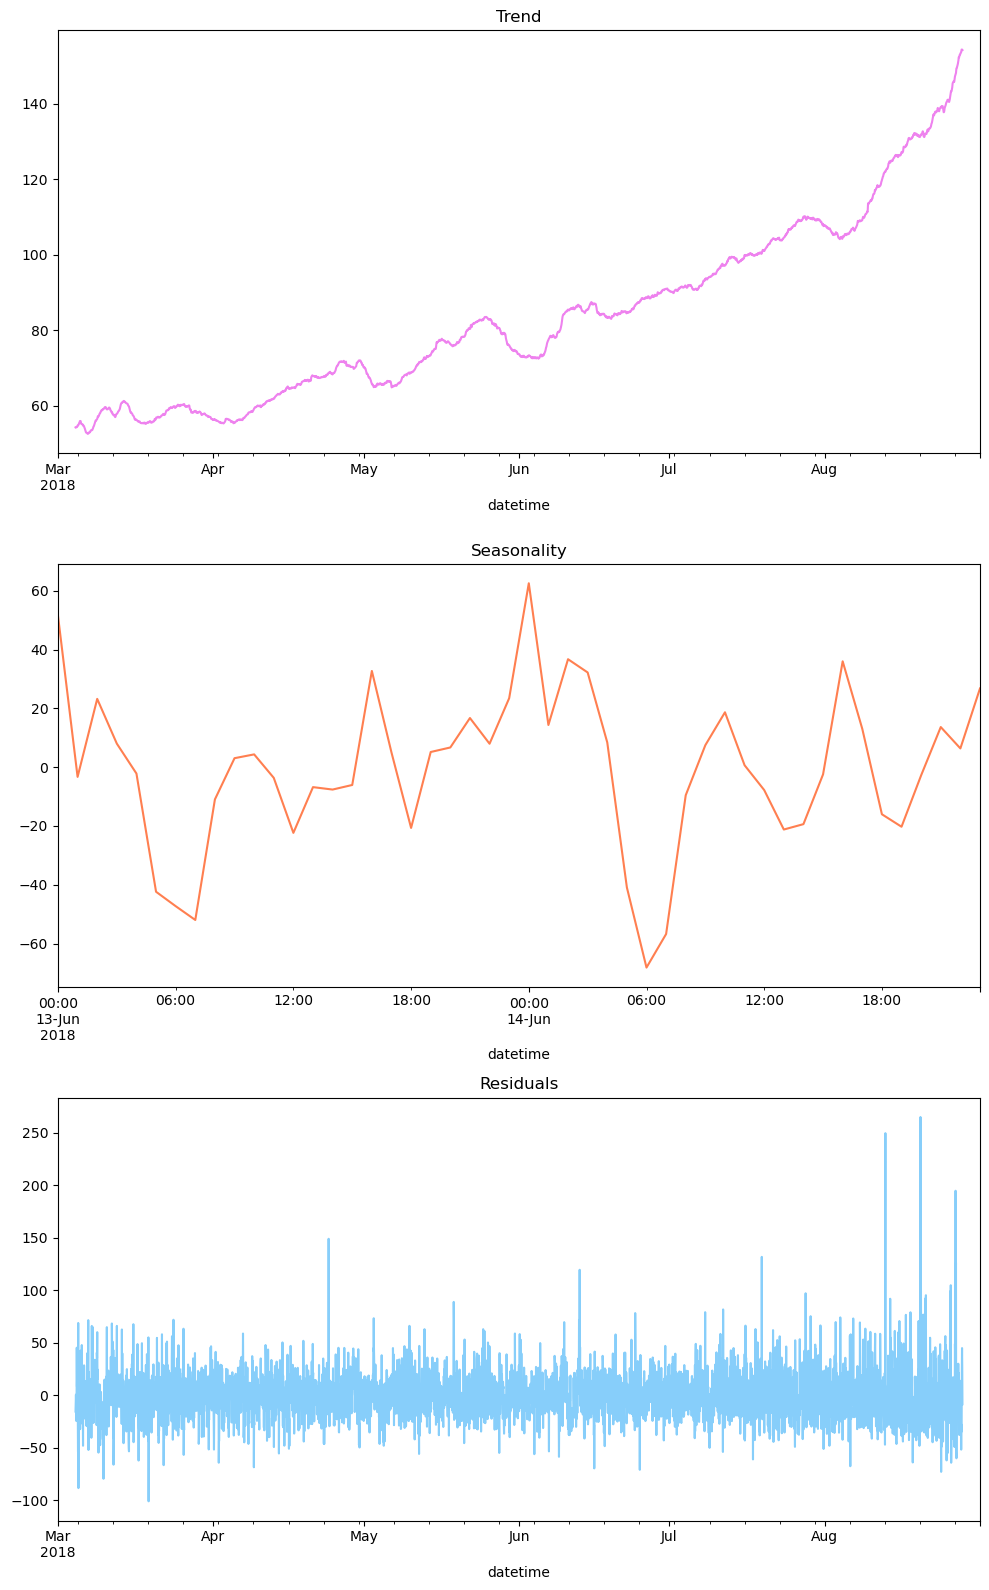

In [6]:
decompose = seasonal_decompose(df, period=24*7)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca(), color='violet')
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-06-13':'2018-06-14'].plot(ax=plt.gca(), color='coral')
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca(), color='lightskyblue')
plt.title('Residuals')

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

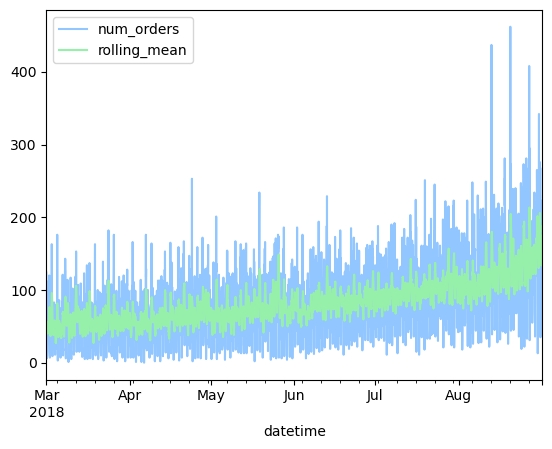

In [7]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot()

Из декомпозиции можно отметить, что тренд указывает на увеличение заказов. Сезоность указывает на высокий спрос на такси в ночное время, потому что в это время не работает общественный транспорт.

Можно сказать, что стохастический процесс нестационарный

In [8]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv('D:/DS/datasets/taxi.csv', index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')




Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


# 3. Обучение

In [9]:
# создаём функцию
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 168, 300)
df.shape

(4416, 172)

In [10]:
df.head(10)

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,3,5,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,3,6,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,3,7,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,NaN,3,8,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


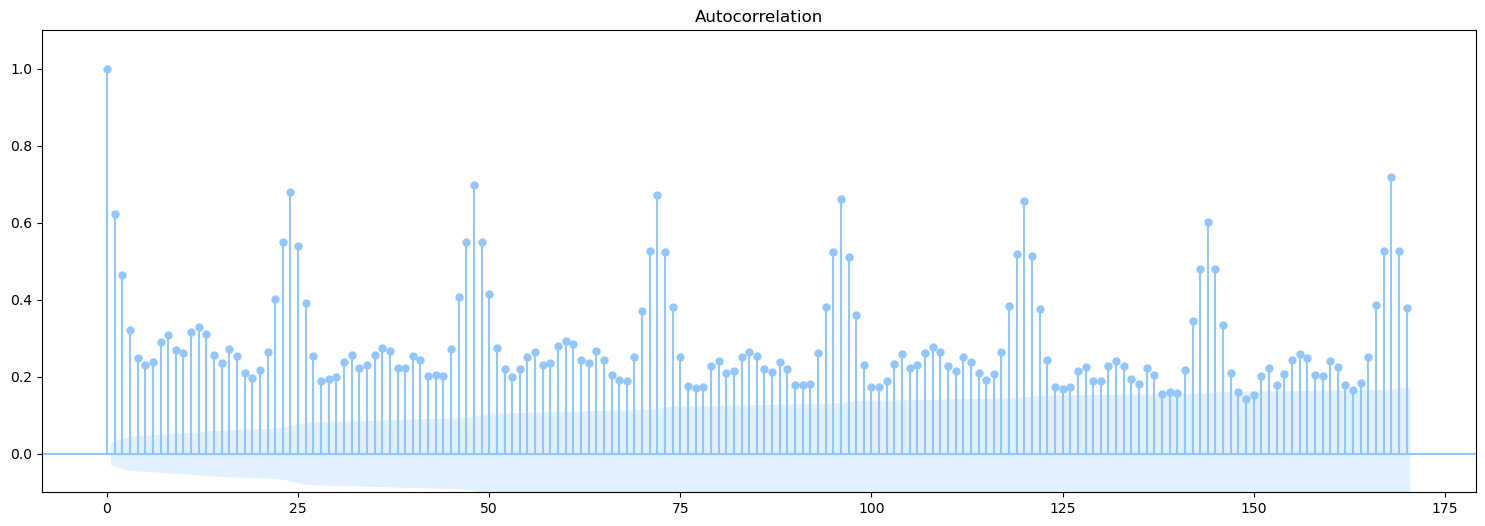

In [11]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv('D:/DS/datasets/taxi.csv', index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 170)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

In [12]:
df.head(10)

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,3,5,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,3,6,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,3,7,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,NaN,3,8,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df = df.dropna()

In [14]:
df.shape

(4116, 172)

In [15]:
df.head(10)

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-13 12:00:00,34,56.523333,1,12,75.0,53.0,44.0,57.0,20.0,15.0,...,58.0,83.0,48.0,51.0,52.0,42.0,63.0,40.0,42.0,41.0
2018-03-13 13:00:00,40,56.223333,1,13,34.0,75.0,53.0,44.0,57.0,20.0,...,81.0,58.0,83.0,48.0,51.0,52.0,42.0,63.0,40.0,42.0
2018-03-13 14:00:00,50,56.073333,1,14,40.0,34.0,75.0,53.0,44.0,57.0,...,47.0,81.0,58.0,83.0,48.0,51.0,52.0,42.0,63.0,40.0
2018-03-13 15:00:00,69,56.003333,1,15,50.0,40.0,34.0,75.0,53.0,44.0,...,100.0,47.0,81.0,58.0,83.0,48.0,51.0,52.0,42.0,63.0
2018-03-13 16:00:00,64,56.013333,1,16,69.0,50.0,40.0,34.0,75.0,53.0,...,121.0,100.0,47.0,81.0,58.0,83.0,48.0,51.0,52.0,42.0
2018-03-13 17:00:00,35,56.083333,1,17,64.0,69.0,50.0,40.0,34.0,75.0,...,24.0,121.0,100.0,47.0,81.0,58.0,83.0,48.0,51.0,52.0
2018-03-13 18:00:00,109,56.180000,1,18,35.0,64.0,69.0,50.0,40.0,34.0,...,66.0,24.0,121.0,100.0,47.0,81.0,58.0,83.0,48.0,51.0
2018-03-13 19:00:00,40,56.503333,1,19,109.0,35.0,64.0,69.0,50.0,40.0,...,73.0,66.0,24.0,121.0,100.0,47.0,81.0,58.0,83.0,48.0
2018-03-13 20:00:00,91,56.586667,1,20,40.0,109.0,35.0,64.0,69.0,50.0,...,10.0,73.0,66.0,24.0,121.0,100.0,47.0,81.0,58.0,83.0


Применим функцию make_features на подготовленный датасет. Разделим датасет (тестовая выборка 10%), попробуем разные модели:

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [17]:
print(train.shape, test.shape)

(3704, 172) (412, 172)


Проведем подбор параметров на модели `LGBMRegressor`:

In [18]:
%%time
LGBMR = LGBMRegressor(n_estimators=200, force_col_wise=True, random_state=111) 
hyperparams = [{'max_depth':[3], 'learning_rate':[0.1]}]
my_cv = TimeSeriesSplit(n_splits=3).split(train_features)
lgbmmodel = GridSearchCV(LGBMR, hyperparams, cv=my_cv, verbose=0, scoring='neg_root_mean_squared_error')
lgbmmodel.fit(train_features, train_target)
print('Best score:', -lgbmmodel.best_score_)
print('Best parameters:', lgbmmodel.best_params_)

Best score: 23.346960988311753
Best parameters: {'learning_rate': 0.1, 'max_depth': 3}
Wall time: 3.1 s


Пробуем модель `CatBoost`:

In [19]:
%%time
catboost = CatBoostRegressor(n_estimators=200, loss_function='MAE', eval_metric='RMSE')
hyperparams = {'max_depth': [3], 'learning_rate': [0.1]}
my_cv = TimeSeriesSplit(n_splits=3).split(train_features)
catboost_model = GridSearchCV(catboost, hyperparams, cv=my_cv, verbose=0, scoring='neg_root_mean_squared_error')
catboost_model.fit(train_features, train_target)
print('Best score:', -catboost_model.best_score_)
print('Best parameters:', catboost_model.best_params_)

0:	learn: 28.9451576	total: 153ms	remaining: 30.4s
1:	learn: 28.0407476	total: 165ms	remaining: 16.3s
2:	learn: 27.0163925	total: 175ms	remaining: 11.5s
3:	learn: 26.2575717	total: 185ms	remaining: 9.07s
4:	learn: 25.4673556	total: 196ms	remaining: 7.64s
5:	learn: 24.8226502	total: 206ms	remaining: 6.67s
6:	learn: 24.0626418	total: 216ms	remaining: 5.96s
7:	learn: 23.4180040	total: 227ms	remaining: 5.45s
8:	learn: 22.8386973	total: 237ms	remaining: 5.03s
9:	learn: 22.5033409	total: 247ms	remaining: 4.69s
10:	learn: 22.0974278	total: 258ms	remaining: 4.43s
11:	learn: 21.6458850	total: 268ms	remaining: 4.21s
12:	learn: 21.3500251	total: 279ms	remaining: 4.01s
13:	learn: 21.1262622	total: 290ms	remaining: 3.85s
14:	learn: 20.9168433	total: 299ms	remaining: 3.69s
15:	learn: 20.4962276	total: 310ms	remaining: 3.56s
16:	learn: 20.3384535	total: 320ms	remaining: 3.44s
17:	learn: 20.2281248	total: 330ms	remaining: 3.34s
18:	learn: 19.9701499	total: 340ms	remaining: 3.24s
19:	learn: 19.7885365	

In [20]:
print(test_features.shape, test_target.shape)

(412, 171) (412,)


# 4. Тестирование

Рассмотрим метрики ранее обученных моделей на тестовой выборке

In [21]:
LGBMR = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, max_depth=3, n_estimators=200)
LGBMR.fit(train_features, train_target)
predicted_test = LGBMR.predict(test_features)
rmse_light_gbm = (mean_squared_error(test_target, predicted_test))**0.5
print('RMSE on test set:', rmse_light_gbm)

RMSE on test set: 37.43366084257447


In [22]:
catboost = CatBoostRegressor(num_leaves=31, learning_rate=0.1, max_depth=3, n_estimators=200)
catboost.fit(train_features, train_target)
predicted_test = catboost.predict(test_features)
rmse_cat = (mean_squared_error(test_target, predicted_test))**0.5
print('RMSE on test set:', rmse_cat)

0:	learn: 37.0641774	total: 19.4ms	remaining: 3.87s
1:	learn: 35.5023003	total: 36.8ms	remaining: 3.64s
2:	learn: 33.9391425	total: 54.7ms	remaining: 3.59s
3:	learn: 32.5852354	total: 71.1ms	remaining: 3.48s
4:	learn: 31.3610260	total: 87.7ms	remaining: 3.42s
5:	learn: 30.3584592	total: 105ms	remaining: 3.39s
6:	learn: 29.3868259	total: 121ms	remaining: 3.35s
7:	learn: 28.6051557	total: 138ms	remaining: 3.3s
8:	learn: 27.8607349	total: 155ms	remaining: 3.28s
9:	learn: 27.1318011	total: 172ms	remaining: 3.26s
10:	learn: 26.5422566	total: 188ms	remaining: 3.22s
11:	learn: 26.0013066	total: 203ms	remaining: 3.19s
12:	learn: 25.5121103	total: 219ms	remaining: 3.15s
13:	learn: 25.0831858	total: 238ms	remaining: 3.16s
14:	learn: 24.6902498	total: 257ms	remaining: 3.17s
15:	learn: 24.3728771	total: 273ms	remaining: 3.13s
16:	learn: 24.0371926	total: 289ms	remaining: 3.11s
17:	learn: 23.7169217	total: 305ms	remaining: 3.08s
18:	learn: 23.5164977	total: 321ms	remaining: 3.06s
19:	learn: 23.2721

In [23]:
pred_lgbm = LGBMR.predict(test_features)
rmse_lgbm_test = mean_squared_error(test_target, pred_lgbm)**0.5
print('RMSE on test set (LightGBM):', rmse_lgbm_test)

RMSE on test set (LightGBM): 37.43366084257447


In [24]:
pred_catboost = catboost.predict(test_features)
rmse_catboost_test = mean_squared_error(test_target, pred_catboost)**0.5
print('RMSE on test set (CatBoost):', rmse_catboost_test)

RMSE on test set (CatBoost): 37.649768955756244


Проверка модели на адекватность по среднему значению: 

In [25]:
pred_mean = np.ones(test.shape[0])*train['num_orders'].mean()
rmse_mean = mean_squared_error(test_target, pred_mean)**0.5
print("RMSE on test set (mean):", rmse_mean)

RMSE on test set (mean): 84.78343242817932


Проверка модели на адекватность по последующему значению: 

In [26]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
rmse_previous = mean_squared_error(test_target, pred_previous)**0.5
print("RMSE on test set (previous):", rmse_previous)

RMSE on test set (previous): 59.420665883012305


По результатам тестирования, модель градиентного бустинга `LightGBM` показала наилучший результат с `RMSE` равным 37.43. В сравнении с другой моделью, моделью `CatBoost`, у которой `RMSE` равен 37.65, `LightGBM` продемонстрировал более точные предсказания. 

Проверка моделей на адекватность показала, что значения `RMSE` для обеих моделей значительно меньше, чем `RMSE` по среднему значению (84.78) и `RMSE` по последующему значению (59.42). 

Градиентный бустинг с использованием `LightGBM` является наилучшей моделью для прогнозирования заказов такси, исходя из результатов тестирования. Эта модель показала более точные и адекватные предсказания в сравнении с моделью `CatBoost`.

Если `RMSE` на тестовой выборке меньше, значит модель адекватна.

In [27]:
min_mean_previous = min(rmse_mean, rmse_previous)

In [28]:
if min_mean_previous > rmse_lgbm_test and min_mean_previous > rmse_catboost_test:
    print('Модель адекватна')
else:
    print(('Модель неадекватна'))

Модель адекватна


В результате лучшая модель это `LightGBM`, значение метрики `RMSE` на лучшей модели на тестовой выборке не превышает указанного в задании 48. 